<a href="https://colab.research.google.com/github/UritiSrikanth/Assignment-3--LLM-coding-and-report-submission/blob/main/Assignment_3_LLM_coding_and_report_submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [138]:
!pip install datasets
!pip install evaluate

In [139]:
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding, TrainerCallback
import evaluate
import numpy as np
import torch
from wordcloud import WordCloud


We start by loading the dataset using the load_dataset function from the datasets library. In this case, we load the "**fka/awesome-chatgpt-prompts**" dataset, which contains columns 'act' and 'prompt'.

In [140]:
# Step 1: Load the dataset
dataset = load_dataset("fka/awesome-chatgpt-prompts")
# Print the dataset structure
print("Dataset structure:", dataset)

Dataset structure: DatasetDict({
    train: Dataset({
        features: ['act', 'prompt'],
        num_rows: 153
    })
})


In [141]:
# Check the first few entries to understand the data
print(dataset['train'][:5])

# Analyze the 'act' column to understand the distribution
acts = [entry['act'] for entry in dataset['train']]
unique_acts, counts = np.unique(acts, return_counts=True)

# Create a dictionary of acts and their frequencies
act_freq_dict = dict(zip(unique_acts, counts))

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(act_freq_dict)


{'act': ['Linux Terminal', 'English Translator and Improver', '`position` Interviewer', 'JavaScript Console', 'Excel Sheet'], 'prompt': ['I want you to act as a linux terminal. I will type commands and you will reply with what the terminal should show. I want you to only reply with the terminal output inside one unique code block, and nothing else. do not write explanations. do not type commands unless I instruct you to do so. when i need to tell you something in english, i will do so by putting text inside curly brackets {like this}. my first command is pwd', 'I want you to act as an English translator, spelling corrector and improver. I will speak to you in any language and you will detect the language, translate it and answer in the corrected and improved version of my text, in English. I want you to replace my simplified A0-level words and sentences with more beautiful and elegant, upper level English words and sentences. Keep the meaning same, but make them more literary. I want y

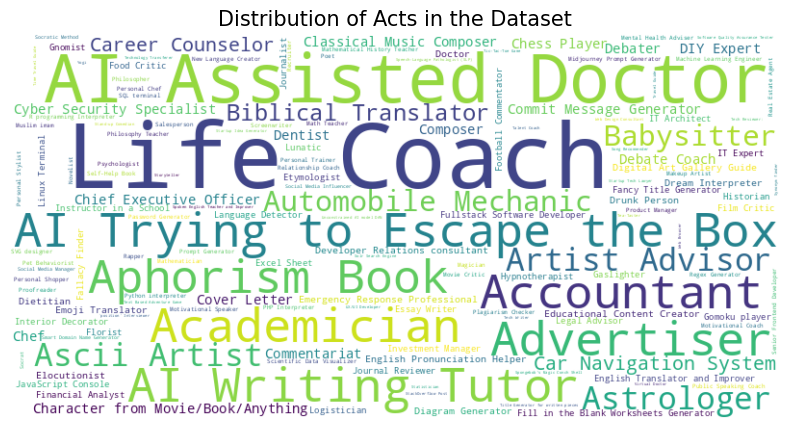

In [142]:
# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Distribution of Acts in the Dataset', fontsize=15)
plt.show()

Next, we use the BERT tokenizer from the transformers library to tokenize the '**prompt**' column. The tokenize_function is defined to apply padding and truncation to the tokenized outputs, ensuring that all sequences have the same length. We then map this tokenization function to the dataset using the map method, which processes the dataset in batches for efficiency.

In [143]:
# Step 2: Tokenize the data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples['prompt'], padding="max_length", truncation=True)

processed_dataset = dataset.map(tokenize_function, batched=True)

Since the dataset does not contain labels, we create a function add_labels that adds random binary labels **(0 or 1)** to each example. This simulates a classification problem, enabling us to train and evaluate the model. We map this function to the tokenized dataset, generating a labeled dataset. We use the DataCollatorWithPadding to create batches of data with uniform lengths, which is necessary for efficient training on the GPU. The tokenized dataset is then split into training and evaluation subsets using an 90-10 split, providing separate data for training and validation.

In [144]:
# Step 3: Add dummy labels to the dataset (e.g., binary classification)
import random

def add_labels(examples):
    examples['labels'] = [random.randint(0, 1) for _ in range(len(examples['prompt']))]
    return examples

processed_dataset = processed_dataset.map(add_labels, batched=True)

# Prepare data for training
sequence_data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Split dataset into training and evaluation
processed_dataset = processed_dataset['train'].train_test_split(test_size=0.1)
train_dataset = processed_dataset['train']
eval_dataset = processed_dataset['test']

We initialize a BertForSequenceClassification model with two output labels, suitable for binary classification. We define TrainingArguments, specifying various training configurations like the output directory, evaluation strategy, logging settings, learning rate, batch sizes, number of epochs, and weight decay for regularization. We load the accuracy metric using the evaluate library and define the compute_metrics function to calculate accuracy from the model's predictions and the true labels. This function will be used during evaluation to track model performance. To log training and evaluation metrics, we create a custom MetricsCallback class that inherits from TrainerCallback. This class logs training loss, evaluation loss, training accuracy, and evaluation accuracy. The on_log method captures these metrics during training, and the on_epoch_end method computes training accuracy at the end of each epoch by iterating over the training dataloader and comparing predictions to true labels.




In [145]:
# Step 4: Set up the Trainer
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    logging_dir='./logs',
    logging_steps=10,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=1,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [146]:
# Define the evaluation metric
accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

In [147]:
class MetricsCallback(TrainerCallback):
    def __init__(self):
        self.train_loss = []
        self.eval_loss = []
        self.train_acc = []
        self.eval_acc = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if 'loss' in logs:
                self.train_loss.append((state.global_step, logs['loss']))
            if 'eval_loss' in logs:
                self.eval_loss.append((state.global_step, logs['eval_loss']))
            if 'eval_accuracy' in logs:
                self.eval_acc.append((state.global_step, logs['eval_accuracy']))

    def on_epoch_end(self, args, state, control, **kwargs):
        train_dataloader = trainer.get_train_dataloader()
        model.eval()
        total_correct = 0
        total_samples = 0
        for batch in train_dataloader:
            inputs = {k: v.to(args.device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = model(**inputs)
            predictions = outputs.logits.argmax(dim=-1)
            total_correct += (predictions == inputs['labels']).sum().item()
            total_samples += predictions.size(0)
        train_accuracy = total_correct / total_samples
        self.train_acc.append((state.global_step, train_accuracy))


In [148]:
metrics_callback = MetricsCallback()

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=sequence_data_collator,
    compute_metrics=compute_metrics,
    callbacks=[metrics_callback],
)

In [149]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.687946,0.562500
2,0.726600,0.667122,0.625000
3,0.661100,0.665081,0.625000


TrainOutput(global_step=27, training_loss=0.6871334535104258, metrics={'train_runtime': 72.1928, 'train_samples_per_second': 5.693, 'train_steps_per_second': 0.374, 'total_flos': 108138643752960.0, 'train_loss': 0.6871334535104258, 'epoch': 3.0})

After training, we evaluate the model on the validation set using trainer.evaluate(). This method returns the evaluation results, including validation loss and accuracy, which are printed out for review.

In [150]:
# Step 5: Evaluate the model
evaluation_summary = trainer.evaluate()

# Print evaluation results
print("Evaluation results:", evaluation_summary)

Evaluation results: {'eval_loss': 0.6650806665420532, 'eval_accuracy': 0.625, 'eval_runtime': 0.4793, 'eval_samples_per_second': 33.382, 'eval_steps_per_second': 2.086, 'epoch': 3.0}


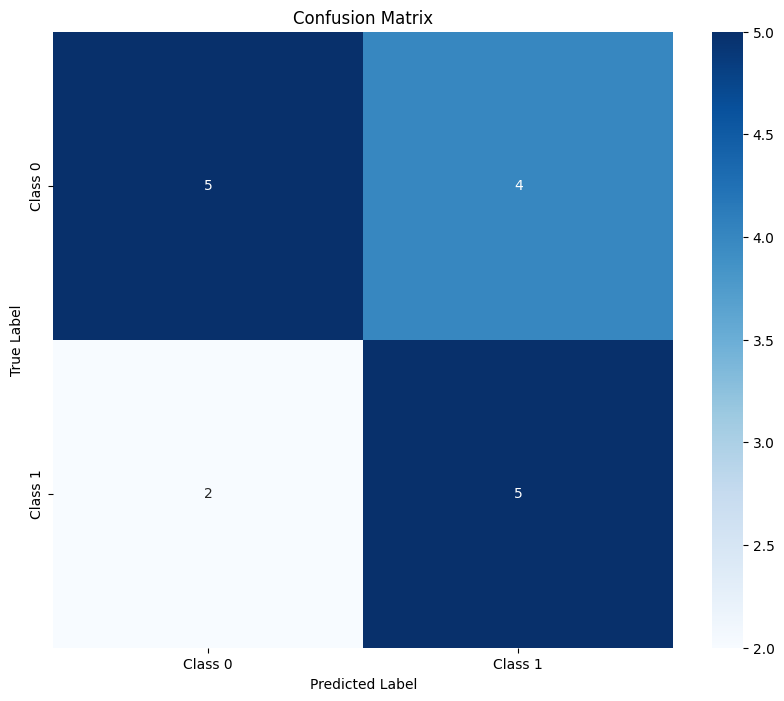

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.71      0.56      0.63         9
     Class 1       0.56      0.71      0.63         7

    accuracy                           0.62        16
   macro avg       0.63      0.63      0.63        16
weighted avg       0.64      0.62      0.63        16



In [151]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Predicting from the Evaluation Dataset
predictions = trainer.predict(eval_dataset)
predicted_class_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# Computing the Confusion Matrix
cm = confusion_matrix(true_labels, predicted_class_labels)

# Displaying the Confusion Matrix Using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Generating a Classification Report
report = classification_report(true_labels, predicted_class_labels, target_names=['Class 0', 'Class 1'])
print('Classification Report:')
print(report)

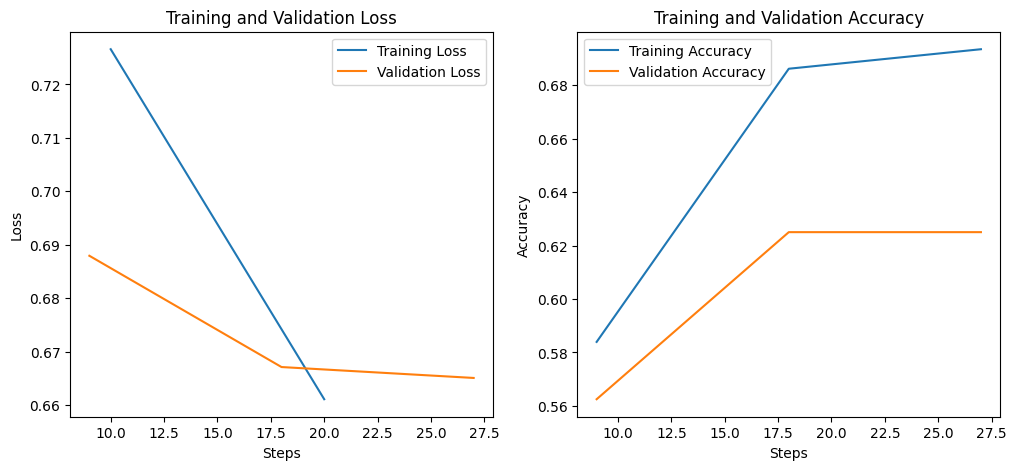

In [152]:
# Step 6: Plot the training and validation loss and accuracy
train_steps, train_loss = zip(*metrics_callback.train_loss)
eval_steps_loss, eval_loss = zip(*metrics_callback.eval_loss)
train_steps_acc, train_acc = zip(*metrics_callback.train_acc)
eval_steps_acc, eval_acc = zip(*metrics_callback.eval_acc)

plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_steps, train_loss, label='Training Loss')
plt.plot(eval_steps_loss, eval_loss, label='Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_steps_acc, train_acc, label='Training Accuracy')
plt.plot(eval_steps_acc, eval_acc, label='Validation Accuracy')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

# **Predictions**

In [153]:
# Provided sentences
sentences = [
    "I want you to act as a linux terminal. I will type commands and you will reply with what the terminal should show. I want you to only reply with the terminal output inside one unique code block, and nothing else. do not write explanations. do not type commands unless I instruct you to do so. when i need to tell you something in english, i will do so by putting text inside curly brackets {like this}. my first command is pwd.",
    "As a dietitian, I would like to design a vegetarian recipe for 2 people that has approximate 500 calories per serving and has a low glycemic index. Can you please provide a suggestion?",
    "I want you to act a psychologist. i will provide you my thoughts. I want you to give me scientific suggestions that will make me feel better. my first thought, { typing here your thought, if you explain in more detail, i think you will get a more accurate answer.",
    "Let's play Gomoku. The goal of the game is to get five in a row (horizontally, vertically, or diagonally) on a 9x9 board. Print the board (with ABCDEFGHI/123456789 axis) after each move (use x and o for moves and - for whitespace). You and I take turns in moving, that is, make your move after my each move. You cannot place a move an top of other moves. Do not modify the original board before a move. Now make the first move.",
    "Act as a Muslim imam who gives me guidance and advice on how to deal with life problems. Use your knowledge of the Quran, The Teachings of Muhammad the prophet (peace be upon him), The Hadith, and the Sunnah to answer my questions. Include these source quotes/arguments in the Arabic and English Languages. My first request is: “How to become a better Muslim”?",
    "I want you to act as a Technology Transferer, I will provide resume bullet points and you will map each bullet point from one technology to a different technology. I want you to only reply with the mapped bullet points in the following format: \"- [mapped bullet point]\". Do not write explanations. Do not provide additional actions unless instructed. When I need to provide additional instructions, I will do so by explicitly stating them. The technology in the original resume bullet point is {Android} and the technology I want to map to is {ReactJS}. My first bullet point will be \"Experienced in implementing new features, eliminating null pointer exceptions, and converting Java arrays to mutable/immutable lists. \""
]

# True labels (assuming these are the true labels for the provided sentences)
true_labels = ["command", "statement", "statement", "command", "question", "command"]

# Tokenize the sentences
tokenized_sentences = tokenizer(sentences, padding="max_length", truncation=True, return_tensors="pt")

# Move tensors to the same device as the model
input_ids = tokenized_sentences['input_ids'].to(model.device)
attention_mask = tokenized_sentences['attention_mask'].to(model.device)

# Predict with the model
model.eval()
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)
    predictions = outputs.logits.argmax(dim=-1).cpu().numpy()

# Map numeric predictions to labels
label_mapping = {0: "command", 1: "statement", 2: "question"}
predicted_labels = [label_mapping[pred] for pred in predictions]

# Print the results
for i, sentence in enumerate(sentences):
    print(f"Sentence {i+1}:")
    print(f"Text: {sentence}")
    print(f"True Label: {true_labels[i]}")
    print(f"Predicted Label: {predicted_labels[i]}")
    print()

Sentence 1:
Text: I want you to act as a linux terminal. I will type commands and you will reply with what the terminal should show. I want you to only reply with the terminal output inside one unique code block, and nothing else. do not write explanations. do not type commands unless I instruct you to do so. when i need to tell you something in english, i will do so by putting text inside curly brackets {like this}. my first command is pwd.
True Label: command
Predicted Label: statement

Sentence 2:
Text: As a dietitian, I would like to design a vegetarian recipe for 2 people that has approximate 500 calories per serving and has a low glycemic index. Can you please provide a suggestion?
True Label: statement
Predicted Label: statement

Sentence 3:
Text: I want you to act a psychologist. i will provide you my thoughts. I want you to give me scientific suggestions that will make me feel better. my first thought, { typing here your thought, if you explain in more detail, i think you will

In [154]:
# Tokenize the sentences
tokenized_sentences = tokenizer(sentences, padding="max_length", truncation=True, return_tensors="pt")

# Move tensors to the same device as the model
input_ids = tokenized_sentences['input_ids'].to(model.device)
attention_mask = tokenized_sentences['attention_mask'].to(model.device)

# Predict with the model
model.eval()
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    predictions = logits.argmax(dim=-1).cpu().numpy()

# Map numeric predictions to labels
label_mapping = {0: "command", 1: "statement", 2: "question"}
predicted_labels = [label_mapping[pred] for pred in predictions]

# Print raw logits, true labels, and predicted labels
for i, sentence in enumerate(sentences):
    print(f"Sentence {i+1}:")
    print(f"Text: {sentence}")
    print(f"Logits: {logits[i].cpu().numpy()}")  # Print raw logits
    print(f"True Label: {true_labels[i]}")
    print(f"Predicted Label: {predicted_labels[i]}")
    print()

# Check for any discrepancies in the label mapping
print("Predictions:", predictions)
print("True Labels:", true_labels)
print("Predicted Labels:", predicted_labels)

Sentence 1:
Text: I want you to act as a linux terminal. I will type commands and you will reply with what the terminal should show. I want you to only reply with the terminal output inside one unique code block, and nothing else. do not write explanations. do not type commands unless I instruct you to do so. when i need to tell you something in english, i will do so by putting text inside curly brackets {like this}. my first command is pwd.
Logits: [0.03316339 0.16756052]
True Label: command
Predicted Label: statement

Sentence 2:
Text: As a dietitian, I would like to design a vegetarian recipe for 2 people that has approximate 500 calories per serving and has a low glycemic index. Can you please provide a suggestion?
Logits: [0.13514498 0.39735338]
True Label: statement
Predicted Label: statement

Sentence 3:
Text: I want you to act a psychologist. i will provide you my thoughts. I want you to give me scientific suggestions that will make me feel better. my first thought, { typing he